In [1]:
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

<Figure size 432x288 with 0 Axes>

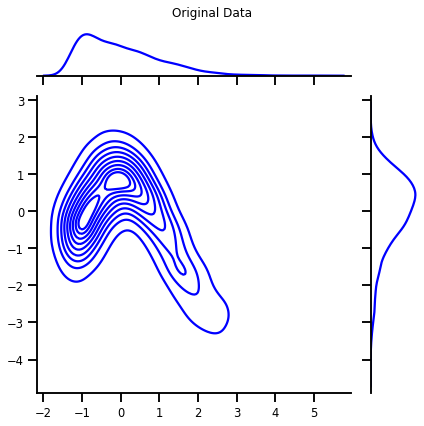

In [3]:
from sklearn.preprocessing import StandardScaler
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(n_samples)
data = StandardScaler().fit_transform(data)

# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

In [4]:
X = jnp.array(data, dtype=np.float32)

## Mixture Distribution

In [5]:
from distrax import Sigmoid, Inverse

In [6]:
sigmoid_layer = Inverse(Sigmoid())

X_, log_det = sigmoid_layer.forward_and_log_det(X)

In [7]:
X_.shape, log_det.shape

((2000, 2), (2000, 2))

<Figure size 432x288 with 0 Axes>

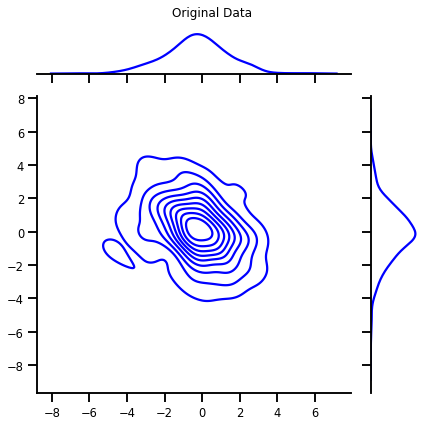

In [8]:
plot_joint(X_, "blue", "Original Data", kind='kde', logger=False)

In [9]:
from distrax._src.utils import jittable
import abc
from chex import Array, dataclass
from typing import Tuple, Optional

In [40]:
from rbig_jax.transforms.base import Bijector
from jax.random import PRNGKey
from chex import Array, dataclass
from rbig_jax.transforms.parametric.mixture.gaussian import mixture_gaussian_cdf_vectorized, mixture_gaussian_invcdf_vectorized, mixture_gaussian_log_pdf_vectorized

### Initialization

In [41]:
from sklearn.cluster import KMeans

def init_means_kmeans(X: np.ndarray, n_components: int, **kwargs):
    """Initialize means with K-Means
    
    Parameters
    ----------
    X : np.ndarray
        (n_samples, n_features)
    n_components : int
        the number of clusters for the K-Means
    
    Returns
    -------
    clusters : np.ndarray
        (n_features, n_components)"""
    clusters = KMeans(n_clusters=n_components, **kwargs).fit(X).cluster_centers_.T
    
    return clusters

def init_means_kmeans_marginal(X: np.ndarray, n_components: int, **kwargs):
    """Initialize means with K-Means
    
    Parameters
    ----------
    X : np.ndarray
        (n_samples, n_features)
    n_components : int
        the number of clusters for the K-Means
    
    Returns
    -------
    clusters : np.ndarray
        (n_features, n_components)"""
    
    clusters = []
    
    for iX in X.T:
        clusters.append(KMeans(n_clusters=n_components, **kwargs).fit(iX[:, None]).cluster_centers_.T)
    
    return np.vstack(clusters)

In [42]:
clusters = init_means_kmeans_marginal(X, 50)
clusters.shape

(2, 50)

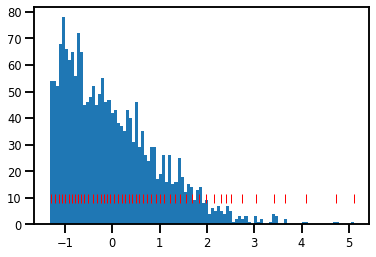

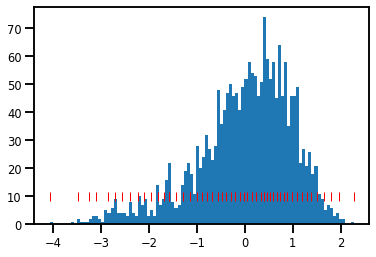

In [43]:
fig, ax = plt.subplots()
ax.hist(X[:, 0], bins=100)
ax.plot(clusters[0], 10*np.ones_like(clusters[1]), "|", color="Red")
plt.show()

fig, ax = plt.subplots()
ax.hist(X[:, 1], bins=100)
ax.plot(clusters[1], 10*np.ones_like(clusters[1]), "|", color="Red")
plt.show()

In [44]:
clusters = init_means_kmeans(X, 50)
clusters.shape

(2, 50)

In [45]:
clusters[0]

array([ 0.3839449 ,  2.0582962 , -0.7272879 , -1.2150801 , -0.02503097,
        0.94571435,  4.8577075 , -0.75723803,  0.75800824,  2.2024114 ,
       -1.090995  , -0.09771159, -0.7248257 ,  1.569465  , -0.38124117,
        3.1448245 ,  0.82576394, -0.09314148, -1.2508256 , -1.0912575 ,
        0.20648365, -0.260833  ,  0.4512955 ,  1.2262403 , -0.14584212,
       -0.6956451 ,  0.6945171 ,  1.8573928 ,  1.4778824 , -0.25966564,
       -0.42879075, -0.6371597 , -0.45327622, -1.1797311 ,  2.9644914 ,
        1.8059158 ,  1.2932731 ,  2.563834  ,  1.017781  , -0.93874997,
       -1.0404598 ,  0.53562593,  1.2072854 ,  0.18004455,  0.19224136,
        1.5892086 ,  0.42109582, -0.8420569 , -0.938325  ,  3.7989082 ],
      dtype=float32)

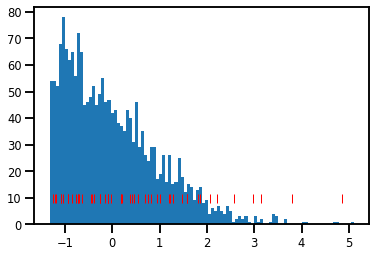

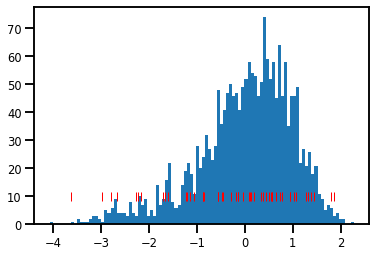

In [46]:
fig, ax = plt.subplots()
ax.hist(X[:, 0], bins=100)
ax.plot(clusters[0], 10*np.ones_like(clusters[1]), "|", color="Red")
plt.show()

fig, ax = plt.subplots()
ax.hist(X[:, 1], bins=100)
ax.plot(clusters[1], 10*np.ones_like(clusters[1]), "|", color="Red")
plt.show()

In [155]:
@dataclass
class MixtureParams:
    means: Array
    log_scales: Array
    prior_logits: Array

class MixtureGaussianCDF(Bijector):
    def __init__(self, n_components: int=10, init_method: str="normal", return_X: bool=False) -> None:
        
        self.n_components = n_components
        self.return_X = return_X
        if init_method.lower() not in ["normal", "kmeans", "kmeans_marg"]:
            raise ValueError(f"unrecognized init method: {init_method}")
        else:
            self.init_method = init_method.lower()
    
    def init_params(self, rng: PRNGKey, n_features: int, X: Optional[Array]=None, **kwargs) -> dataclass:
        # initialize mixture

        if self.init_method == "kmeans" and X is not None:
            
            means = init_means_kmeans_marginal(X, self.n_components, **kwargs)
            means = jnp.array(means, dtype=jnp.float32)
        elif self.init_method == "kmeans_marg" and X is not None:
            
            means = init_means_kmeans(X, self.n_components, **kwargs)
            means = jnp.array(means, dtype=jnp.float32)
        else:
            means = jax.random.normal(key=rng, shape=(n_features, self.n_components))
            
        log_scales = jnp.zeros((n_features, self.n_components))
        prior_logits = jnp.ones((n_features, self.n_components)) / self.n_components

        init_params = MixtureParams(
            means=means, log_scales=log_scales, prior_logits=prior_logits
        )
        
        if self.return_X:
        
            return self.forward(init_params, X), init_params
        else:
            return init_params
    
    def forward_and_log_det(self,
        params: dataclass, inputs: Array,
    ) -> Tuple[Array, Array]:
        print(type(inputs))
        print(type(params.prior_logits))
        print(type(params.means))
        print(type(params.log_scales))
        # forward transformation with batch dimension
        outputs = mixture_gaussian_cdf_vectorized(
            inputs, params.prior_logits, params.means, np.exp(params.log_scales),
        )

        # log abs det, all zeros
        logabsdet = mixture_gaussian_log_pdf_vectorized(
            inputs, params.prior_logits, params.means, np.exp(params.log_scales),
        )

        return outputs, logabsdet

    def inverse_and_log_det(self,
        params: dataclass, inputs: Array, 
    ) -> Tuple[Array, Array]:

        # transformation
        outputs = mixture_gaussian_invcdf_vectorized(
            inputs, params.prior_logits, params.means, np.exp(params.log_scales),
        )
        # log abs det, all zeros
        logabsdet = mixture_gaussian_log_pdf_vectorized(
            outputs, params.prior_logits, params.means, np.exp(params.log_scales),
        )

        return outputs, logabsdet

<class 'jax.interpreters.xla._DeviceArray'>
<class 'jax.interpreters.xla._DeviceArray'>
<class 'jax.interpreters.xla._DeviceArray'>
<class 'jax.interpreters.xla._DeviceArray'>


<Figure size 432x288 with 0 Axes>

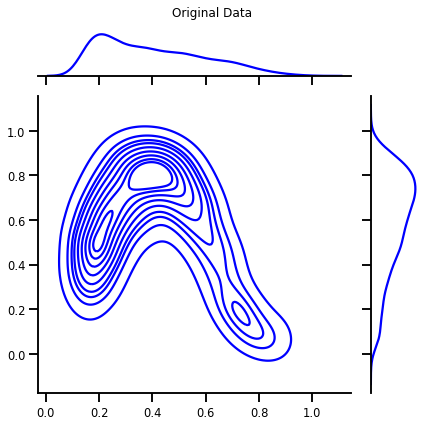

In [156]:
mcdf_layer = MixtureGaussianCDF(10, "kmeans_marg", True)

# initialize the keys
KEY = jax.random.PRNGKey(123)
rng, params_rng = jax.random.split(KEY, 2)

# initialize params
X_l1, params = mcdf_layer.init_params(params_rng, 2, X=X)



plot_joint(X_l1, "blue", "Original Data", kind='kde', logger=False)

### Forwad Transformation

In [157]:
f = jax.jit(mcdf_layer.forward_and_log_det)
f(params, X)

<class 'jax.interpreters.partial_eval.DynamicJaxprTracer'>
<class 'jax.interpreters.partial_eval.DynamicJaxprTracer'>
<class 'jax.interpreters.partial_eval.DynamicJaxprTracer'>
<class 'jax.interpreters.partial_eval.DynamicJaxprTracer'>


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[2,10])>with<DynamicJaxprTrace(level=0/1)> (https://jax.readthedocs.io/en/latest/errors.html#jax._src.errors.TracerArrayConversionError)

<Figure size 432x288 with 0 Axes>

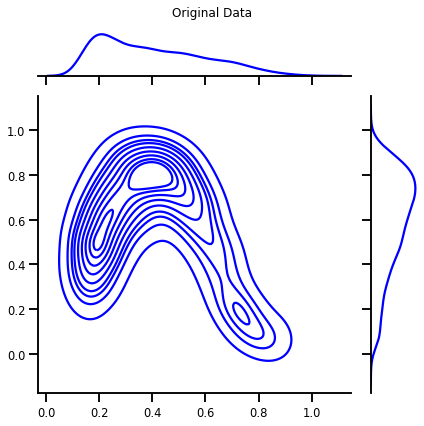

In [49]:
# transformation
X_l1 = mcdf_layer.forward(params, X)

plot_joint(X_l1, "blue", "Original Data", kind='kde', logger=False)

In [50]:
X_approx = mcdf_layer.inverse(params, X_l1)

<Figure size 432x288 with 0 Axes>

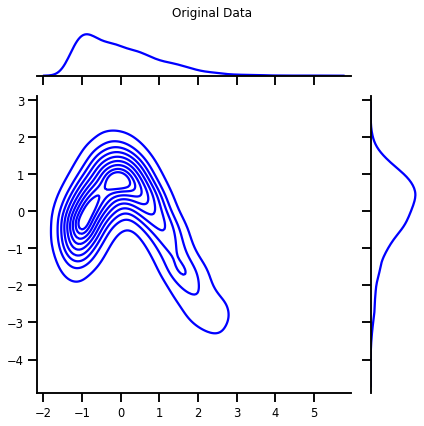

In [51]:
plot_joint(X_approx, "blue", "Original Data", kind='kde', logger=False)

## Logit Transform

In [52]:
from distrax._src.bijectors.sigmoid import _more_stable_sigmoid, _more_stable_softplus


# def _more_stable_sigmoid(x):
#     """Where extremely negatively saturated, approximate sigmoid with exp(x)."""
#     x = np.
#     x = jnp.where(x < -9, jnp.exp(x), jax.nn.sigmoid(x))
#     return x


class Logit(Bijector):
    def __init__(self, eps: float=1e-5, return_X: bool=True) -> None:
        
        self.eps = eps
        self.return_X = return_X
    
    def init_params(self, rng: PRNGKey, n_features: int, **kwargs) -> dataclass:
        
        
        if self.return_X:
        
            return self.forward((),X), ()
        else:
            return ()
    
    def inverse_and_log_det(self,
        params: dataclass, x: Array, **kwargs
    ) -> Tuple[Array, Array]:
        return _more_stable_sigmoid(x), self.forward_log_det_jacobian(params, x)

    def inverse_log_det_jacobian(self, params: dataclass, x: Array) -> Array:
        return -_more_stable_softplus(-x) - _more_stable_softplus(x)
    
    def forward_and_log_det(self,
        params: dataclass, x: Array, **kwargs
    ) -> Tuple[Array, Array]:
        
        x = np.clip(x, self.eps, 1 - self.eps)

        y = jnp.log(x) - jnp.log1p(-x)

        return y, -self.inverse_log_det_jacobian(params, y)

In [53]:
logit_layer = Logit()

# initialize the keys
KEY = jax.random.PRNGKey(123)
rng, logit_rng = jax.random.split(rng, 2)

# initialize params
X_l2, params = logit_layer.init_params(logit_rng, 2, X=X)


params, X_l2.min(), X_l2.max()

((),
 DeviceArray(-11.512916, dtype=float32),
 DeviceArray(11.511558, dtype=float32))

### Forward Transform

<Figure size 432x288 with 0 Axes>

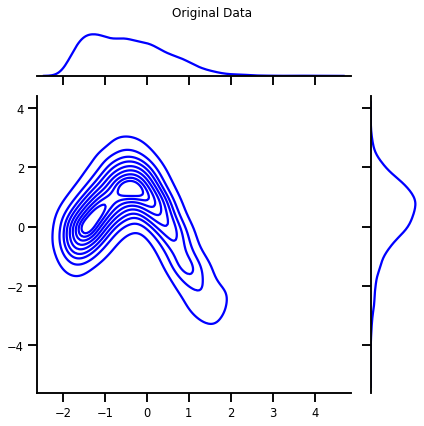

In [54]:
# transformation
# X_l2 = sigmoid_layer.forward(X_l1)#l
X_l2 = logit_layer.forward(params, X_l1)

plot_joint(X_l2, "blue", "Original Data", kind='kde', logger=False)

### Inverse Transformation

<Figure size 432x288 with 0 Axes>

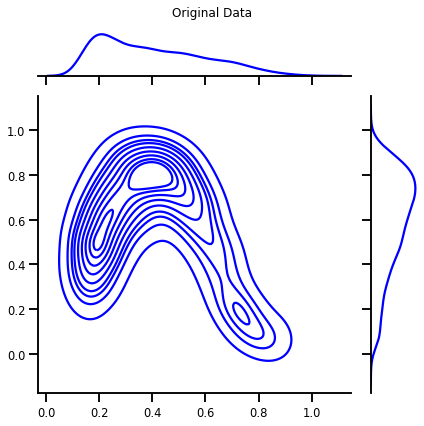

In [55]:
# transformation
X_l1_approx = logit_layer.inverse(params, X_l2)

plot_joint(X_l1_approx, "blue", "Original Data", kind='kde', logger=False)

In [56]:
X.min(), X.max(), X_l1.min(), X_l1.max(), X_l2.min(), X_l2.max()

(DeviceArray(-4.066332, dtype=float32),
 DeviceArray(5.107872, dtype=float32),
 DeviceArray(0.00918143, dtype=float32),
 DeviceArray(0.98358846, dtype=float32),
 DeviceArray(-4.681349, dtype=float32),
 DeviceArray(4.0932226, dtype=float32))

## Rotation

In [69]:
from rbig_jax.transforms.parametric.householder import householder_transform, householder_inverse_transform
from rbig_jax.transforms.rotation import compute_projection
@dataclass
class HouseHolderParams:
    V: Array


class HouseHolder(Bijector):
    def __init__(self, n_reflections: int=10, init_method: str="random", return_X: bool=False) -> None:
        
        self.n_reflections = n_reflections
        self.return_X = return_X
        if init_method.lower() not in ["random", "pca"]:
            raise ValueError(f"unrecognized init method: {init_method}")
        else:
            self.init_method = init_method.lower()
    
    def init_params(self, rng: PRNGKey, n_features: int,  X: Optional[Array]=None, **kwargs) -> dataclass:
        # initialize mixture

        if self.init_method == "ica" and X is not None:
            
            raise NotImplementedError(f"ICA method hasn't been implemented yet.")
        elif self.init_method == "pca" and X is not None:
            
            V = compute_projection(X)
        elif self.init_method == "random":
            V = jax.nn.initializers.orthogonal()(key=rng, shape=(self.n_reflections, n_features))
        else:
            raise ValueError(f"Unrecognized method: {self.init_method}")
            
        init_params = HouseHolderParams(V=V)
        
        if self.return_X:
            
#             if self.init_method in ["pca", "ica"]:
#                 return np.dot(X, V), init_params
#             else:
                
            return self.forward(init_params, X), init_params
        else:
            return init_params
    
    def forward_and_log_det(self,
        params: HouseHolderParams, inputs: Array, **kwargs
    ) -> Tuple[Array, Array]:

        # forward transformation with batch dimension
        outputs = jax.vmap(householder_transform, in_axes=(0, None))(
            inputs, params.V
        )

        # log abs det, all zeros
        logabsdet = np.zeros_like(inputs)

        return outputs, logabsdet

    def inverse_and_log_det(self,
        params: HouseHolderParams, inputs: Array, **kwargs
    ) -> Tuple[Array, Array]:

        outputs = jax.vmap(householder_inverse_transform, in_axes=(0, None))(
            inputs, params.V
        )

        # log abs det, all zeros
        logabsdet = np.zeros_like(inputs)

        return outputs, logabsdet

## Householder Transformation

In [70]:
X_t = np.random.randn(100,10)

<Figure size 432x288 with 0 Axes>

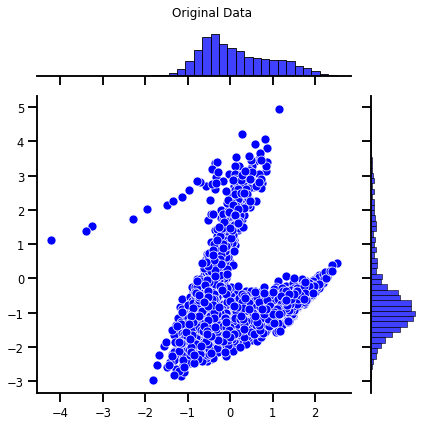

In [71]:
hh_layer = HouseHolder(50, "random", True)

# initialize the keys
KEY = jax.random.PRNGKey(123)
rng, hh_rng = jax.random.split(rng, 2)

# initialize params
X_l3, params = hh_layer.init_params(hh_rng, 2, X=X_l2)


plot_joint(X_l3, "blue", "Original Data", kind='scatter', logger=False)

### Forward Transformation

<Figure size 432x288 with 0 Axes>

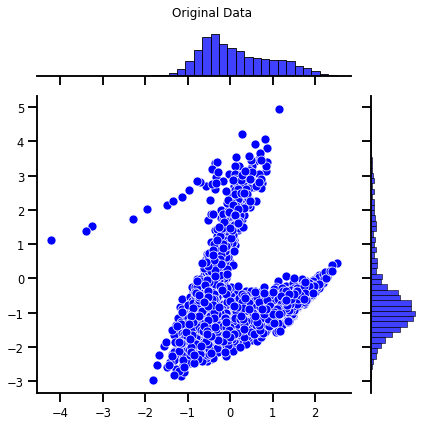

In [72]:
# transformation
X_l3 = hh_layer.forward(params, X_l2)

plot_joint(X_l3, "blue", "Original Data", kind='scatter', logger=False)

## Chaining Transformations

In [104]:
# initialize params stores
all_params, forward_funs, inverse_funs = [], [], []

n_layers = 3
# create keys for all inits
rng, params_rng = jax.random.split(KEY, num=2)

bijectors = []
params = []

X_l = X

print(X_l.min(), X_l.max())
plot_layers = False

if plot_layers:
    plot_joint(X_l, "blue", f"L:{0}", kind='kde', logger=False)

# loop through bijectors
for i in range(1, n_layers+1):
    print(i)
    # ==============
    # Layer I
    # ==============
    # initialize layer
    mcdf_layer = MixtureGaussianCDF(10, "kmeans", True)
    
    # initialize params
    params_rng, layer_rngs = jax.random.split(params_rng, num=2)

    X_l, mcdf_params = mcdf_layer.init_params(params_rng, 2, X=X_l)
    print(X_l.min(), X_l.max())
    
    # Plot
    if plot_layers:
        plot_joint(X_l, "blue", f"L:{i} (MG)", kind='kde', logger=False)

    
    # append layer
    bijectors.append(mcdf_layer)
    params.append(mcdf_params)
    
    # ==============
    # Layer II
    # ==============
    # initialize layer
    logit_layer = Logit(return_X=True)
    
    # initialize params
    params_rng, layer_rngs = jax.random.split(params_rng, num=2)
    
    X_l, logit_params = logit_layer.init_params(logit_rng, 2, X=X_l)
    print(X_l.min(), X_l.max())

    # append layer
    bijectors.append(logit_layer)
    params.append(logit_params)
    
    # Plot
    if plot_layers:
        plot_joint(X_l, "blue", f"L:{i} (ICDF)", kind='kde', logger=False)
    
    # ==============
    # Layer III
    # ==============

    # initialize layer
    hh_layer = HouseHolder(10, "pca", True)
    
    # initialize params
    params_rng, layer_rngs = jax.random.split(params_rng, num=2)

    X_l, hh_params = hh_layer.init_params(hh_rng, 2, X=X_l)
    
    # append layer
    bijectors.append(hh_layer)
    params.append(hh_params)
    
    # plot
    if plot_layers:
        plot_joint(X_l, "blue", f"L:{i} (Rotation)", kind='kde', logger=False)
    print(X_l.min(), X_l.max())
    break


#     param, forward_f, inverse_f = init_f(rng=i_rng, n_features=n_features)
    
#     # store functions and parameters
#     all_params.append(param)
#     forward_funs.append(forward_f)
#     inverse_funs.append(inverse_f)

-4.066332 5.107872
1
0.016886655 0.9893361
-11.512916 11.511558
-11.5115595 11.5129175


### Convenience Function

In [98]:
from rbig_jax.transforms.base import Chain

In [99]:
flow = Chain(bijectors)

In [117]:
params[2].V

DeviceArray([[-0.7966377, -0.6044571],
             [ 0.6044571, -0.7966377]], dtype=float32)

In [130]:
f = flow.forward

In [129]:
%%time
X_l3 = f(params, X)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[2,10])>with<DynamicJaxprTrace(level=0/1)> (https://jax.readthedocs.io/en/latest/errors.html#jax._src.errors.TracerArrayConversionError)

In [127]:
%%time
X_l3 = f(params, X.block_until_ready())

CPU times: user 188 ms, sys: 9.91 ms, total: 198 ms
Wall time: 173 ms


<Figure size 432x288 with 0 Axes>

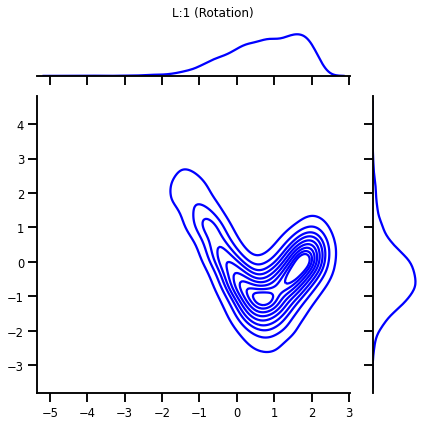

In [93]:
plot_joint(X_l3, "blue", f"L:{i} (Rotation)", kind='kde', logger=False)

In [72]:
X_l.min(), X.max()

(-16.255688, DeviceArray(5.107872, dtype=float32))

In [73]:
# initialize params stores
all_params, forward_funs, inverse_funs = [], [], []

# create keys for all inits
rng, *layer_rngs = jax.random.split(KEY, num=len(bijectors) + 1)

# loop through bijectors
for i_rng, init_f in zip(layer_rngs, bijectors):
    
    # Layer I
    
    
    # Layer II
    
    
    # Layer III
    
    param, forward_f, inverse_f = init_f(rng=i_rng, n_features=n_features)
    
    # store functions and parameters
    all_params.append(param)
    forward_funs.append(forward_f)
    inverse_funs.append(inverse_f)

TypeError: 'MixtureGaussianCDF' object is not callable